## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [5]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [6]:
train, test = keras.datasets.cifar10.load_data()

In [7]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [8]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization, Dropout
from keras.regularizers import l1, l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], name="l1", ratio=1e-4, drp_ratio=0.25, state='dropout'):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    if name == "l1":
        regularizer = l1(ratio)
    elif name == "l2":
        regularizer = l2(ratio)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                activation="relu", 
                                name="hidden_layer"+str(i+1), 
                                kernel_regularizer=regularizer)(input_layer)
            if state=='dropout':
                x = Dropout(drp_ratio)(x)
            elif state=='bn':
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                activation="relu", 
                                name="hidden_layer"+str(i+1),
                                kernel_regularizer=regularizer)(x)
            if state=='dropout':
                x = Dropout(drp_ratio)(x)
            elif state=='bn':
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [10]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

NAME =  ["l1" ,"l2"]
state = ["dropout" ,"bn"]

In [11]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for name in NAME:
    for stat in state:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(" %s >>> %s" %(name,stat))
        model = build_mlp(input_shape=x_train.shape[1:], name=name, state=stat)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=(x_test, y_test), 
                shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
        
        exp_name_tag = " %s >>> %s" %(name,stat)
        results[exp_name_tag] = {'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc}

 l1 >>> dropout
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)     

196/196 [==============================] - 4s 21ms/step - loss: 2.9326 - accuracy: 0.5180 - val_loss: 2.9188 - val_accuracy: 0.5178
Epoch 49/50
196/196 [==============================] - 4s 21ms/step - loss: 2.8997 - accuracy: 0.5210 - val_loss: 2.8569 - val_accuracy: 0.5294
Epoch 50/50
196/196 [==============================] - 4s 22ms/step - loss: 2.8600 - accuracy: 0.5189 - val_loss: 2.8283 - val_accuracy: 0.5240
 l1 >>> bn
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)     

196/196 [==============================] - 4s 22ms/step - loss: 2.2586 - accuracy: 0.8393 - val_loss: 4.0318 - val_accuracy: 0.4327
Epoch 46/50
196/196 [==============================] - 4s 22ms/step - loss: 2.2148 - accuracy: 0.8447 - val_loss: 4.3125 - val_accuracy: 0.4181
Epoch 47/50
196/196 [==============================] - 4s 22ms/step - loss: 2.1979 - accuracy: 0.8388 - val_loss: 4.0925 - val_accuracy: 0.4075
Epoch 48/50
196/196 [==============================] - 4s 22ms/step - loss: 2.1504 - accuracy: 0.8468 - val_loss: 4.2829 - val_accuracy: 0.3912
Epoch 49/50
196/196 [==============================] - 4s 22ms/step - loss: 2.1096 - accuracy: 0.8514 - val_loss: 4.3719 - val_accuracy: 0.4036
Epoch 50/50
196/196 [==============================] - 4s 22ms/step - loss: 2.0919 - accuracy: 0.8441 - val_loss: 4.1326 - val_accuracy: 0.4159
 l2 >>> dropout
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape          

196/196 [==============================] - 4s 21ms/step - loss: 1.4769 - accuracy: 0.5224 - val_loss: 1.4749 - val_accuracy: 0.5221
Epoch 43/50
196/196 [==============================] - 4s 21ms/step - loss: 1.4719 - accuracy: 0.5230 - val_loss: 1.4749 - val_accuracy: 0.5242
Epoch 44/50
196/196 [==============================] - 4s 21ms/step - loss: 1.4643 - accuracy: 0.5264 - val_loss: 1.4658 - val_accuracy: 0.5229
Epoch 45/50
196/196 [==============================] - 4s 22ms/step - loss: 1.4612 - accuracy: 0.5271 - val_loss: 1.4679 - val_accuracy: 0.5269
Epoch 46/50
196/196 [==============================] - 4s 22ms/step - loss: 1.4507 - accuracy: 0.5303 - val_loss: 1.4528 - val_accuracy: 0.5326
Epoch 47/50
196/196 [==============================] - 4s 22ms/step - loss: 1.4406 - accuracy: 0.5353 - val_loss: 1.4505 - val_accuracy: 0.5287
Epoch 48/50
196/196 [==============================] - 4s 21ms/step - loss: 1.4453 - accuracy: 0.5324 - val_loss: 1.4528 - val_accuracy: 0.5309
Epoc

196/196 [==============================] - 4s 22ms/step - loss: 0.4342 - accuracy: 0.9114 - val_loss: 2.5211 - val_accuracy: 0.4565
Epoch 40/50
196/196 [==============================] - 4s 22ms/step - loss: 0.4262 - accuracy: 0.9119 - val_loss: 2.2774 - val_accuracy: 0.4742
Epoch 41/50
196/196 [==============================] - 4s 22ms/step - loss: 0.4109 - accuracy: 0.9171 - val_loss: 2.4945 - val_accuracy: 0.4511
Epoch 42/50
196/196 [==============================] - 4s 22ms/step - loss: 0.3939 - accuracy: 0.9243 - val_loss: 2.4432 - val_accuracy: 0.4601
Epoch 43/50
196/196 [==============================] - 4s 22ms/step - loss: 0.3848 - accuracy: 0.9265 - val_loss: 2.5025 - val_accuracy: 0.4570
Epoch 44/50
196/196 [==============================] - 4s 22ms/step - loss: 0.3710 - accuracy: 0.9332 - val_loss: 2.3786 - val_accuracy: 0.4759
Epoch 45/50
196/196 [==============================] - 4s 22ms/step - loss: 0.3570 - accuracy: 0.9377 - val_loss: 2.7235 - val_accuracy: 0.4463
Epoc

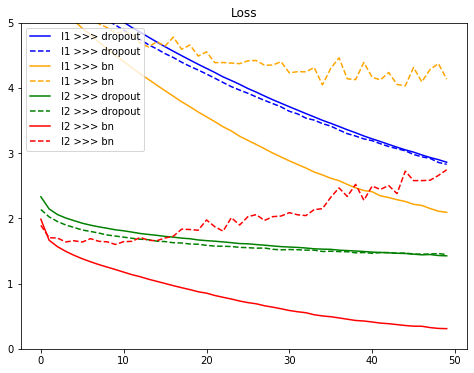

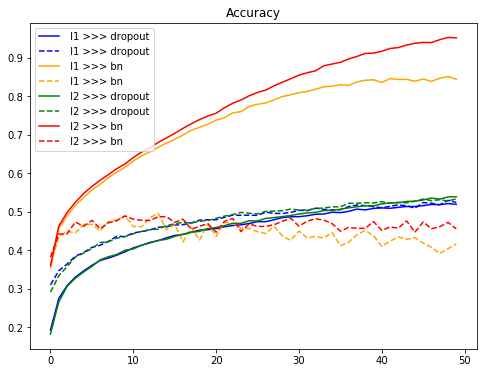

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["Blue", "Orange", "Green", "Red", "Purple", "Brown" ,"pink" , "gray"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()